# OJOS CERRADOS

/var/folders/mw/l9rx69d95757bgwlzlg35qjc0000gn/T/ipykernel_5971/3121113358.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = {k: np.trapz(Pxx[(f>=a)&(f<=b)], f[(f>=a)&(f<=b)]) for k,(a,b) in BANDAS.items()}


[Basal 1] Potencias (µV²)  α:6.895  β:9.267  γ:2.405


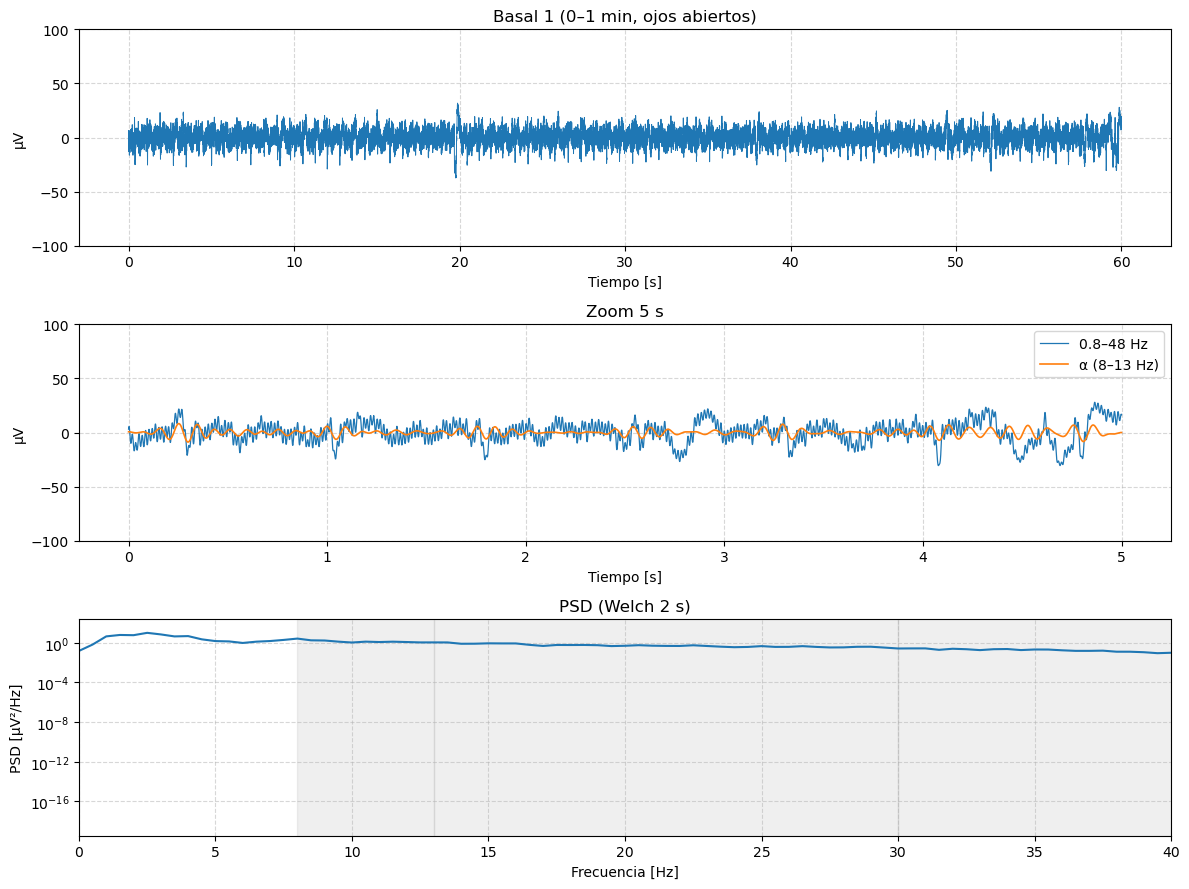

In [18]:
import json, re, numpy as np, matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch

# ===== Config =====
ruta = "Data_EEG/lab5.txt"
bloque = (0, 60)               # 0–1 min
zoom_window = 5.0              # s
f_lo, f_hi = 0.8, 48.0         # Hz
red, Q_notch = 50.0, 30.0      # cambia red=60.0 si tu red es 60 Hz
BANDAS = {"alpha":(8,13), "beta":(13,30), "gamma":(30,48)}

# ===== Header: fs y columna A4 =====
with open(ruta,"r",encoding="utf-8",errors="ignore") as f:
    hdr=[]
    while True:
        p=f.tell(); ln=f.readline()
        if not ln: break
        if ln.startswith("#"): hdr.append(ln[1:].strip())
        else: f.seek(p); break
meta = json.loads(re.search(r"\{.*\}", "\n".join(hdr), re.DOTALL).group(0))
dev = next(iter(meta)); fs = int(meta[dev]["sampling rate"])
idx_A4 = meta[dev]["column"].index("A4")

# ===== Carga y conversión ADC→µV =====
adc = np.genfromtxt(ruta, usecols=[idx_A4], comments="#", dtype=float); adc = adc[~np.isnan(adc)]
Vref, gain = 3.3, 40000.0
x = (adc - 512.0) * (Vref/1023.0)/gain*1e6  # µV

# ===== Filtros =====
bN,aN = iirnotch(red/(fs/2), Q_notch); x = filtfilt(bN,aN,x,method="gust")
bB,aB = butter(4, [f_lo/(fs/2), f_hi/(fs/2)], btype="band"); x = filtfilt(bB,aB,x,method="gust")

# ===== Recorte =====
i1,i2 = int(bloque[0]*fs), min(int(bloque[1]*fs), len(x))
t = np.arange(len(x))/fs; t_seg, x_seg = t[i1:i2], x[i1:i2]

# ===== Welch (2 s) y potencias =====
f, Pxx = welch(x_seg, fs=fs, nperseg=2*fs, noverlap=fs)
bp = {k: np.trapz(Pxx[(f>=a)&(f<=b)], f[(f>=a)&(f<=b)]) for k,(a,b) in BANDAS.items()}
print("[Basal 1] Potencias (µV²)  α:{:.3f}  β:{:.3f}  γ:{:.3f}".format(bp["alpha"], bp["beta"], bp["gamma"]))

# ===== Zoom 5 s (final del bloque) =====
t2z = t_seg[-1]; t1z = max(t2z-zoom_window, t_seg[0])
j1,j2 = int(t1z*fs), int(t2z*fs)
t_zoom, x_zoom = t[j1:j2], x[j1:j2]
bA,aA = butter(4, [8/(fs/2), 13/(fs/2)], btype="band"); x_alpha = filtfilt(bA,aA,x_zoom,method="gust")

# ===== Plots =====
plt.figure(figsize=(12,9))
ax1=plt.subplot(3,1,1); ax1.plot(t_seg-t_seg[0], x_seg, lw=.7)
ax1.set_title("Basal 1 (0–1 min, ojos abiertos)"); ax1.set_xlabel("Tiempo [s]"); ax1.set_ylabel("µV")
ax1.grid(True,ls="--",alpha=.5); ax1.set_ylim(-100,100)

ax2=plt.subplot(3,1,2)
ax2.plot(t_zoom-t_zoom[0], x_zoom, lw=.9, label="0.8–48 Hz")
ax2.plot(t_zoom-t_zoom[0], x_alpha, lw=1.2, label="α (8–13 Hz)")
ax2.set_title("Zoom 5 s"); ax2.set_xlabel("Tiempo [s]"); ax2.set_ylabel("µV")
ax2.grid(True,ls="--",alpha=.5); ax2.legend(); ax2.set_ylim(-100,100)

ax3=plt.subplot(3,1,3)
ax3.semilogy(f, Pxx)
for a,b in BANDAS.values(): ax3.axvspan(a,b,color="grey",alpha=.12)
ax3.set_xlim(0,40); ax3.set_xlabel("Frecuencia [Hz]"); ax3.set_ylabel("PSD [µV²/Hz]")
ax3.set_title("PSD (Welch 2 s)"); ax3.grid(True,ls="--",alpha=.5)
plt.tight_layout(); plt.show()
